In [1]:
import time
import sys
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt, numpy as np


import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, accuracy_score, \
    precision_score, recall_score

from cancernet import PnetDataSet

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

print(device)

cuda


In [3]:
## Pytorch dataset for prostate data
dataset = PnetDataSet(
    root="./data/prostate",
    name="prostate_graph_humanbase",
    #files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose([T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]))


## loads the train/valid/test split from pnet
dataset.split_index_by_file(
    train_fp="./data/prostate/splits/training_set_0.csv",
    valid_fp="./data/prostate/splits/validation_set.csv",
    test_fp="./data/prostate/splits/test_set.csv"
)



In [4]:
inputs = 3
hidden = 128
outputs = 2

class EdgeModel(torch.nn.Module):
    def __init__(self):
        super(EdgeModel, self).__init__()
        self.edge_mlp = Seq(Lin(inputs*2, hidden), 
                            BatchNorm1d(hidden),
                            ReLU(),
                            Lin(hidden, hidden))

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest], 1)
        return self.edge_mlp(out)


class NodeModel(torch.nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = Seq(Lin(inputs+hidden, hidden), 
                              BatchNorm1d(hidden),
                              ReLU(), 
                              Lin(hidden, hidden))
        self.node_mlp_2 = Seq(Lin(inputs+hidden, hidden), 
                              BatchNorm1d(hidden),
                              ReLU(), 
                              Lin(hidden, hidden))

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)
    
class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(hidden, hidden),                               
                              BatchNorm1d(hidden),
                              ReLU(), 
                              Lin(hidden, outputs))

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = scatter_mean(x, batch, dim=0)
        return self.global_mlp(out)


class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        self.interactionnetwork  = MetaLayer(EdgeModel(), NodeModel(), GlobalModel())
        
    def forward(self, x, edge_index, edge_attr, batch):
        
        x, edge_attr, u = self.interactionnetwork(x, edge_index, edge_attr, None, batch)
        return F.log_softmax(u, dim=-1)

In [5]:
batch = 10

# prep data
train_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True,
)

data=next(iter(train_loader))
data[0]

Data(x=[9054, 3], edge_index=[2, 15080], edge_attr=[15080], y=[1], subject_id='TCGA-HC-7752', edge_weight=[15080], adj_t=[9054, 9054, nnz=15080])

Text(0, 0.5, 'Frequency')

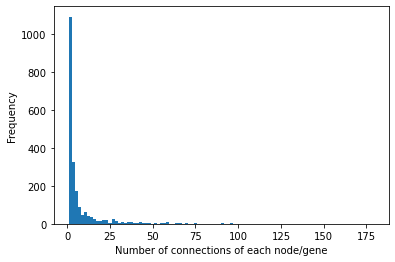

In [6]:
data=next(iter(train_loader))
edge_indices=data[0].edge_index.cpu().numpy()
edge_counter=1
connections=[]
gene=edge_indices[1][0]
for aa in range(len(data[0].edge_index[0])):
    if gene==edge_indices[1][aa]:
        edge_counter+=1
    else:
        gene=edge_indices[1][aa]
        connections.append(edge_counter)
        edge_counter=1
    #print(edge_indices[1][aa])
    
plt.hist(connections,bins=100);
plt.xlabel("Number of connections of each node/gene");
plt.ylabel("Frequency")

In [7]:
parall = False
lr = 0.001

model=InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=20)
criterion = F.nll_loss

In [8]:
t0 = time.time()
def train(epoch, report=True, progbar=False):
    model.train()
    global t0
    total_loss = 0
    correct = 0
    num_samps = 0
    gen = tqdm.tqdm(train_loader) if progbar is True else train_loader
    for data in gen:
        if not parall:
            data = data.to(device)
        optimizer.zero_grad()

        output = model(data.x,data.edge_index,data.edge_attr,data.batch)
        output = output.squeeze()

        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y

        if len(output.shape) == 1:
            output = output.unsqueeze(0)
        loss = criterion(output, y)

        pred = output.max(1)[1]
        correct += pred.eq(y).sum().item()
        total_loss += loss * batch
        loss.backward()
        optimizer.step()
        num_samps += len(y)
    if report:
        print(
            "Epoch: {:02d}, Loss: {:.3g}, Train Acc: {:.4f}, Time lapsed: {:.1f} s".format(
                epoch, total_loss / num_samps, correct / num_samps,
                time.time() - t0
            )
        )
        t0 = time.time()

    return total_loss / num_samps, correct / num_samps

def valid():
    model.eval()
    correct = 0

    total_loss = 0
    num_samps = 0
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data.x,data.edge_index,data.edge_attr,data.batch)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item() * batch

        correct += pred.eq(y).sum().item()
        num_samps += len(y)
    return total_loss / num_samps, correct / num_samps

In [9]:
# run training
train_losses = []
train_acces = []
valid_acces = []
valid_losses = []
for epoch in range(1, 200):
    report = (epoch) % 10 == 0
    train_loss, train_acc = train(epoch, report=report)
    valid_loss, valid_acc = valid()
    scheduler.step(valid_loss)
    train_losses.append(train_loss.cpu().detach().numpy())
    valid_losses.append(valid_loss)
    train_acces.append(train_acc)
    valid_acces.append(valid_acc)
    if report:
        print("valid Loss: {:.3g}, Acc: {:.4f}".format(valid_loss, valid_acc))

Epoch: 10, Loss: 0.488, Train Acc: 0.7675, Time lapsed: 14.3 s
valid Loss: 0.508, Acc: 0.7700
Epoch: 20, Loss: 0.483, Train Acc: 0.7775, Time lapsed: 13.6 s
valid Loss: 0.515, Acc: 0.7800
Epoch: 30, Loss: 0.483, Train Acc: 0.7975, Time lapsed: 13.6 s
valid Loss: 0.503, Acc: 0.7200
Epoch: 40, Loss: 0.46, Train Acc: 0.8000, Time lapsed: 13.6 s
valid Loss: 0.491, Acc: 0.7900
Epoch: 50, Loss: 0.447, Train Acc: 0.7975, Time lapsed: 13.7 s
valid Loss: 0.462, Acc: 0.8100
Epoch: 60, Loss: 0.433, Train Acc: 0.8187, Time lapsed: 13.7 s
valid Loss: 0.457, Acc: 0.7800
Epoch: 70, Loss: 0.445, Train Acc: 0.8125, Time lapsed: 13.7 s
valid Loss: 0.461, Acc: 0.7700
Epoch: 80, Loss: 0.443, Train Acc: 0.8113, Time lapsed: 13.7 s
valid Loss: 0.472, Acc: 0.7600
Epoch: 90, Loss: 0.424, Train Acc: 0.8313, Time lapsed: 13.7 s
valid Loss: 0.469, Acc: 0.7600
Epoch: 100, Loss: 0.442, Train Acc: 0.8075, Time lapsed: 13.7 s
valid Loss: 0.442, Acc: 0.7900
Epoch: 110, Loss: 0.435, Train Acc: 0.7963, Time lapsed: 13.

Text(0, 0.5, 'Valid accuracy')

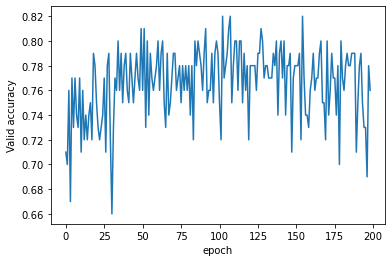

In [10]:
plt.plot(valid_acces)
plt.xlabel("epoch")
plt.ylabel("Valid accuracy")

Text(0.5, 0, 'epoch')

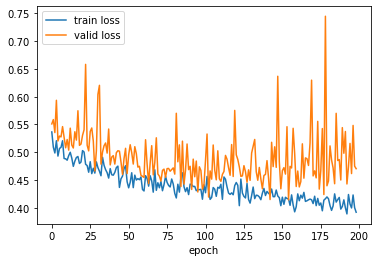

In [11]:
plt.plot(train_losses,label="train loss")
plt.plot(valid_losses,label="valid loss")
plt.legend()
plt.xlabel("epoch")
#plt.yscale("log")

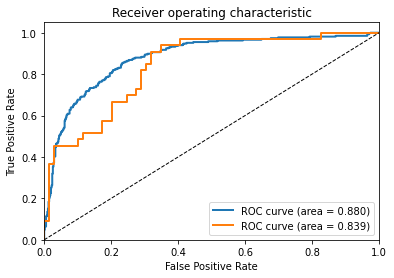

In [12]:
# vis training + validation metrics
loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb.x,tb.edge_index,tb.edge_attr,tb.batch)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_train, tpr_train, _ = roc_curve(ys, outs[:, 1])
train_auc = auc(fpr_train, tpr_train)

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb.x,tb.edge_index,tb.edge_attr,tb.batch)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
valid_auc = auc(fpr_valid, tpr_valid)

plt.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
plt.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [13]:
# testing performance

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb.x,tb.edge_index,tb.edge_attr,tb.batch)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs[:, 1]>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs[:, 1]))
print('f1', f1_score(ys, outs[:, 1]>0.5))
print('precision', precision_score(ys, outs[:, 1]>0.5))
print('recall', recall_score(ys, outs[:, 1]>0.5))

accuracy 0.8137254901960784
auc 0.9039792387543253
aupr 0.8360390476165014
f1 0.6415094339622641
precision 0.8947368421052632
recall 0.5
